<a href="https://colab.research.google.com/github/mfrdixon/alpha-RNN/blob/master/Alpha_RNNs_regime_switching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Alpha RNN Regime Switching Example
# Author: 
# Version: 1.0 (12.2.2020)
# License: 
# Email: 
# Notes: tested on Mac OS X with Python 3.6 and TensorFlow 1.4

In [0]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import pandas as pd
from numpy import random
import os# Generate switching data set
import random

from IPython import display
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU, SimpleRNN
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.regularizers import l1,l2
from keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
#from alphaRNN import *
from keras.layers import Layer
from keras import backend as K
from keras import layers
import keras.layers
from keras import *
from keras.legacy import interfaces
from sklearn.preprocessing import StandardScaler

from alphaRNN import *
from alphatRNN import *
	
from numpy.random import seed
from tensorflow import set_random_seed
set_random_seed(2)

%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [0]:
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=50, min_delta=1e-8, restore_best_weights=True)

# Data Generation

In [0]:
def generate_rs_sample(length, sigma_0, n_steps, step_size, p, eps=0.01, shift=0):
    sigma = np.array([0]*length, dtype='float64')
    sigma[0]=sigma_0
    mu = np.array([0]*length, dtype='float64')
    phi = np.array([0]*length*p, dtype='float64').reshape(length,p)
    step_length=100 
    
    for i in range(2*n_steps):

      mu[i*step_length:((i+1)*step_length)]= step_size*(-1)**i
      if i%2==0:  
        phi[i*step_length:((i+1)*step_length),:]= 0.02
      else:
        phi[i*step_length:((i+1)*step_length),:]=0.01
    
    for i in range(p, length):
        sigma[i]= mu[i-1] + np.random.normal(0,eps)
        for j in range(p):
          sigma[i]+=phi[i-1,j]*sigma[i-j]  
        
    return (sigma+shift)

In [0]:
p = 30 # the number of lags used for the DGP
np.random.seed(0)
data=generate_rs_sample(20000, 0.25, 150, 0.1, p, 1e-4, 0.13)[p:]
df = pd.DataFrame(data, columns=['y'])
target = 'y'
use_features = [target] 
n_steps = 20 # number of lags to include in the model
train_weight = 0.8  # train/test split
split = int(len(df)*train_weight)
df_train = df[use_features].iloc[:split]
df_test = df[use_features].iloc[split:]

## Statistical diagnostics

## Augmented Dickey-Fuller test

In [0]:
adf, p, usedlag, nobs, cvs,aic=sm.tsa.stattools.adfuller(df[target][:2000])
print(adf,p, nobs, cvs)

-3.2810394829898897 0.01574757804048544 1999 {'1%': -3.4336254962865045, '5%': -2.862986937508278, '10%': -2.567540287745173}


Text(0.5,0,'lag (j)')

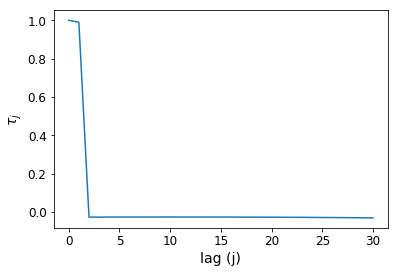

In [0]:
pacf=sm.tsa.stattools.pacf(data, nlags=30)
#n_steps=np.where(np.array(np.abs(pacf)>2.58/np.sqrt(len(df_p)))==False)[0][0] -1
plt.plot(pacf)
plt.ylabel('$\\tau_j$')
plt.xlabel('lag (j)')

### Data structure manipulation for RNNs

In [0]:
def get_lagged_features(value, n_steps,n_steps_ahead):
    """
    value: feature value to be lagged
    n_steps: number of lags, i.e. sequence length
    n_steps_ahead: forecasting horizon
    """
    lag_list = []
    for lag in range(n_steps+n_steps_ahead-1, n_steps_ahead-1, -1):
        lag_list.append(value.shift(lag))
    return pd.concat(lag_list, axis=1)

In [0]:
n_steps_ahead=10 # forecasting horizon

x_train_list = []
for use_feature in use_features:
    x_train_reg = get_lagged_features(df_train, n_steps, n_steps_ahead).dropna()
    x_train_list.append(x_train_reg)
x_train_reg = pd.concat(x_train_list, axis=1)

col_ords = []
for i in range(n_steps):
    for j in range(len(use_features)):
        col_ords.append(i + j * n_steps)

x_train_reg = x_train_reg.iloc[:, col_ords]
y_train_reg = df_train.loc[x_train_reg.index, [target]].values
x_train_reg = np.reshape(x_train_reg.values, (x_train_reg.shape[0], np.int(x_train_reg.shape[1] / len(use_features)), len(use_features)))
y_train_reg = np.reshape(y_train_reg, (y_train_reg.shape[0], 1, 1))

x_test_list = []
for use_feature in use_features:
    x_test_reg = get_lagged_features(df_test, n_steps,n_steps_ahead).dropna()
    x_test_list.append(x_test_reg)
x_test_reg = pd.concat(x_test_list, axis=1)

x_test_reg = x_test_reg.iloc[:, col_ords]
y_test_reg = df_test.loc[x_test_reg.index, [target]].values
x_test_reg = np.reshape(x_test_reg.values, (x_test_reg.shape[0], np.int(x_test_reg.shape[1]/len(use_features)), len(use_features)))

y_test_reg = np.reshape(y_test_reg, (y_test_reg.shape[0], 1, 1))

In [0]:
print(x_train_reg.shape,y_train_reg.shape,x_test_reg.shape,y_test_reg.shape)

(15947, 20, 1) (15947, 1, 1) (3965, 20, 1) (3965, 1, 1)


In [0]:
train_batch_size = y_train_reg.shape[0]
test_batch_size = y_test_reg.shape[0]

In [0]:
print(train_batch_size)

15947


In [0]:
x_train_reg = pd.concat(x_train_list, axis=1)
x_train_reg = x_train_reg.iloc[:, col_ords]
y_train_reg = df_train.loc[x_train_reg.index, [target]].values
x_train_reg = np.reshape(x_train_reg.values, (x_train_reg.shape[0], np.int(x_train_reg.shape[1] / len(use_features)), len(use_features)))


x_test_reg = pd.concat(x_test_list, axis=1)
x_test_reg = x_test_reg.iloc[:, col_ords]
y_test_reg = df_test.loc[x_test_reg.index, [target]].values
x_test_reg = np.reshape(x_test_reg.values, (x_test_reg.shape[0], np.int(x_test_reg.shape[1]/len(use_features)), len(use_features)))

In [0]:
def AlphatRNN_(n_units = 10, l1_reg=0, seed=0):
  model = Sequential()
  model.add(AlphatRNN(n_units, activation='tanh', recurrent_activation='sigmoid', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=l1(l1_reg), input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))  
  model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model


def AlphaRNN_(n_units = 10, l1_reg=0, seed=0):
  model = Sequential()
  model.add(AlphaRNN(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=l1(l1_reg), input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
  model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model


def SimpleRNN_(n_units = 10, l1_reg=0, seed=0):
  model = Sequential()
  model.add(SimpleRNN(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=l1(l1_reg), input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True, stateful=False))  
  model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model


def GRU_(n_units = 10, l1_reg=0, seed=0):
  model = Sequential()
  model.add(GRU(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=l1(l1_reg), input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))  
  model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model


def LSTM_(n_units = 10, l1_reg=0, seed=0):
  model = Sequential()
  model.add(LSTM(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=l1(l1_reg), input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True)) 
  model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

In [0]:
max_epoches=2000
batch_size=1000

In [0]:
params = {'rnn': {'model':'', 'function':SimpleRNN_, 'l1_reg':0.001, 'H':20, 'color': 'blue', 'label':'RNN'}, 
          'alpharnn': {'model':'', 'function':AlphaRNN_,'l1_reg':0.001, 'H':20,'color': 'green', 'label': '$\\alpha$-RNN' }, 
          'alphatrnn': {'model':'', 'function':AlphatRNN_,'l1_reg':0.0, 'H':20, 'color': 'cyan', 'label': '$\\alpha_t$-RNN'},
          'gru': {'model':'', 'function':GRU_,'l1_reg':0.0, 'H':10, 'color': 'orange', 'label': 'GRU'},
          'lstm': {'model':'', 'function':LSTM_,'l1_reg':0.001, 'H':5, 'color':'red', 'label': 'LSTM'}
         }

# Cross-validation

In [0]:
cross_val=False # Warning: Changing this to True will take several hours to run
if cross_val:
    n_units = [5,10,20]
    l1_reg = [0, 0.001, 0.01, 0.1]
    tscv = TimeSeriesSplit(n_splits = 5)
    param_grid = dict(n_units=n_units,l1_reg=l1_reg)

    for key in params.keys(): # params[key]['function']
        model = KerasRegressor(build_fn=params[key]['function'], epochs=max_epoches, batch_size=batch_size, verbose=2)
        grid = GridSearchCV(estimator=model,param_grid=param_grid, cv=tscv, n_jobs=1, verbose=2)
        grid_result = grid.fit(x_train_reg,y_train_reg,callbacks=[es])
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params_ = grid_result.cv_results_['params']
        for mean, stdev, param_ in zip(means, stds, params_):
            print("%f (%f) with %r" % (mean, stdev, param_))

    params[key]['H'] = grid_result.best_params_['n_units']
    params[key]['l1_reg']= grid_result.best_params_['l1_reg']

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] l1_reg=0, n_units=5 .............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/2000
 - 6s - loss: 5.5408
Epoch 2/2000
 - 0s - loss: 5.4404
Epoch 3/2000
 - 0s - loss: 5.3331
Epoch 4/2000
 - 0s - loss: 5.2281
Epoch 5/2000
 - 0s - loss: 5.1251
Epoch 6/2000
 - 0s - loss: 5.0249
Epoch 7/2000
 - 0s - loss: 4.9272
Epoch 8/2000
 - 0s - loss: 4.8329
Epoch 9/2000
 - 0s - loss: 4.7411
Epoch 10/2000
 - 0s - loss: 4.6522
Epoch 11/2000
 - 0s - loss: 4.5659
Epoch 12/2000
 - 0s - loss: 4.4826
Epoch 13/2000
 - 0s - loss: 4.4018
Epoch 14/2000
 - 0s - loss: 4.3232
Epoch 15/2000
 - 0s - loss: 4.2467
Epoch 16/2000
 - 0s - loss: 4.1723
Epoch 17/2000
 - 0s - loss: 4.1000
Epoch 18/2000
 - 0s - loss: 4.0298
Epoch 19/2000
 - 0s - loss: 3.9613
Epoch 20/2000
 - 0s - loss: 3.8946
Epoch 21/2000
 - 0s - loss: 3.8297
Epoch 22/2000
 - 0s - loss: 3.7664
Epoch 23/2000
 - 0s - loss: 3.7046
Epoch 24/2000
 - 0s - loss: 3.6443
Epoch 25/2000
 - 0s - loss: 3.5855
Epoch 26/2000
 - 0s - loss: 3.5284
Epoch 27/2000
 - 0s - loss: 3.4724
Epoch 28/2000
 - 0s - loss: 3.4178
Epoch 29/2000
 - 0s - loss: 3

Epoch 232/2000
 - 0s - loss: 0.0179
Epoch 233/2000
 - 0s - loss: 0.0179
Epoch 234/2000
 - 0s - loss: 0.0179
Epoch 235/2000
 - 0s - loss: 0.0179
Epoch 236/2000
 - 0s - loss: 0.0178
Epoch 237/2000
 - 0s - loss: 0.0178
Epoch 238/2000
 - 0s - loss: 0.0178
Epoch 239/2000
 - 0s - loss: 0.0178
Epoch 240/2000
 - 0s - loss: 0.0177
Epoch 241/2000
 - 0s - loss: 0.0177
Epoch 242/2000
 - 0s - loss: 0.0177
Epoch 243/2000
 - 0s - loss: 0.0177
Epoch 244/2000
 - 0s - loss: 0.0176
Epoch 245/2000
 - 0s - loss: 0.0176
Epoch 246/2000
 - 0s - loss: 0.0176
Epoch 247/2000
 - 0s - loss: 0.0176
Epoch 248/2000
 - 0s - loss: 0.0175
Epoch 249/2000
 - 0s - loss: 0.0175
Epoch 250/2000
 - 0s - loss: 0.0175
Epoch 251/2000
 - 0s - loss: 0.0175
Epoch 252/2000
 - 0s - loss: 0.0175
Epoch 253/2000
 - 0s - loss: 0.0174
Epoch 254/2000
 - 0s - loss: 0.0174
Epoch 255/2000
 - 0s - loss: 0.0174
Epoch 256/2000
 - 0s - loss: 0.0174
Epoch 257/2000
 - 0s - loss: 0.0173
Epoch 258/2000
 - 0s - loss: 0.0173
Epoch 259/2000
 - 0s - loss:

Epoch 460/2000
 - 0s - loss: 0.0131
Epoch 461/2000
 - 0s - loss: 0.0131
Epoch 462/2000
 - 0s - loss: 0.0131
Epoch 463/2000
 - 0s - loss: 0.0130
Epoch 464/2000
 - 0s - loss: 0.0130
Epoch 465/2000
 - 0s - loss: 0.0130
Epoch 466/2000
 - 0s - loss: 0.0130
Epoch 467/2000
 - 0s - loss: 0.0130
Epoch 468/2000
 - 0s - loss: 0.0129
Epoch 469/2000
 - 0s - loss: 0.0129
Epoch 470/2000
 - 0s - loss: 0.0129
Epoch 471/2000
 - 0s - loss: 0.0129
Epoch 472/2000
 - 0s - loss: 0.0129
Epoch 473/2000
 - 0s - loss: 0.0129
Epoch 474/2000
 - 0s - loss: 0.0128
Epoch 475/2000
 - 0s - loss: 0.0128
Epoch 476/2000
 - 0s - loss: 0.0128
Epoch 477/2000
 - 0s - loss: 0.0128
Epoch 478/2000
 - 0s - loss: 0.0128
Epoch 479/2000
 - 0s - loss: 0.0127
Epoch 480/2000
 - 0s - loss: 0.0127
Epoch 481/2000
 - 0s - loss: 0.0127
Epoch 482/2000
 - 0s - loss: 0.0127
Epoch 483/2000
 - 0s - loss: 0.0127
Epoch 484/2000
 - 0s - loss: 0.0126
Epoch 485/2000
 - 0s - loss: 0.0126
Epoch 486/2000
 - 0s - loss: 0.0126
Epoch 487/2000
 - 0s - loss:

Epoch 688/2000
 - 0s - loss: 0.0092
Epoch 689/2000
 - 0s - loss: 0.0092
Epoch 690/2000
 - 0s - loss: 0.0091
Epoch 691/2000
 - 0s - loss: 0.0091
Epoch 692/2000
 - 0s - loss: 0.0091
Epoch 693/2000
 - 0s - loss: 0.0091
Epoch 694/2000
 - 0s - loss: 0.0091
Epoch 695/2000
 - 0s - loss: 0.0091
Epoch 696/2000
 - 0s - loss: 0.0091
Epoch 697/2000
 - 0s - loss: 0.0090
Epoch 698/2000
 - 0s - loss: 0.0090
Epoch 699/2000
 - 0s - loss: 0.0090
Epoch 700/2000
 - 0s - loss: 0.0090
Epoch 701/2000
 - 0s - loss: 0.0090
Epoch 702/2000
 - 0s - loss: 0.0090
Epoch 703/2000
 - 0s - loss: 0.0089
Epoch 704/2000
 - 0s - loss: 0.0089
Epoch 705/2000
 - 0s - loss: 0.0089
Epoch 706/2000
 - 0s - loss: 0.0089
Epoch 707/2000
 - 0s - loss: 0.0089
Epoch 708/2000
 - 0s - loss: 0.0089
Epoch 709/2000
 - 0s - loss: 0.0089
Epoch 710/2000
 - 0s - loss: 0.0088
Epoch 711/2000
 - 0s - loss: 0.0088
Epoch 712/2000
 - 0s - loss: 0.0088
Epoch 713/2000
 - 0s - loss: 0.0088
Epoch 714/2000
 - 0s - loss: 0.0088
Epoch 715/2000
 - 0s - loss:

Epoch 916/2000
 - 0s - loss: 0.0063
Epoch 917/2000
 - 0s - loss: 0.0063
Epoch 918/2000
 - 0s - loss: 0.0063
Epoch 919/2000
 - 0s - loss: 0.0063
Epoch 920/2000
 - 0s - loss: 0.0063
Epoch 921/2000
 - 0s - loss: 0.0063
Epoch 922/2000
 - 0s - loss: 0.0063
Epoch 923/2000
 - 0s - loss: 0.0063
Epoch 924/2000
 - 0s - loss: 0.0063
Epoch 925/2000
 - 0s - loss: 0.0063
Epoch 926/2000
 - 0s - loss: 0.0063
Epoch 927/2000
 - 0s - loss: 0.0063
Epoch 928/2000
 - 0s - loss: 0.0063
Epoch 929/2000
 - 0s - loss: 0.0063
Epoch 930/2000
 - 0s - loss: 0.0062
Epoch 931/2000
 - 0s - loss: 0.0062
Epoch 932/2000
 - 0s - loss: 0.0062
Epoch 933/2000
 - 0s - loss: 0.0062
Epoch 934/2000
 - 0s - loss: 0.0062
Epoch 935/2000
 - 0s - loss: 0.0062
Epoch 936/2000
 - 0s - loss: 0.0062
Epoch 937/2000
 - 0s - loss: 0.0062
Epoch 938/2000
 - 0s - loss: 0.0062
Epoch 939/2000
 - 0s - loss: 0.0062
Epoch 940/2000
 - 0s - loss: 0.0062
Epoch 941/2000
 - 0s - loss: 0.0062
Epoch 942/2000
 - 0s - loss: 0.0062
Epoch 943/2000
 - 0s - loss:

Epoch 1140/2000
 - 0s - loss: 0.0058
Epoch 1141/2000
 - 0s - loss: 0.0058
Epoch 1142/2000
 - 0s - loss: 0.0058
Epoch 1143/2000
 - 0s - loss: 0.0058
Epoch 1144/2000
 - 0s - loss: 0.0058
Epoch 1145/2000
 - 0s - loss: 0.0058
Epoch 1146/2000
 - 0s - loss: 0.0058
Epoch 1147/2000
 - 0s - loss: 0.0058
Epoch 1148/2000
 - 0s - loss: 0.0058
Epoch 1149/2000
 - 0s - loss: 0.0058
Epoch 1150/2000
 - 0s - loss: 0.0058
Epoch 1151/2000
 - 0s - loss: 0.0058
Epoch 1152/2000
 - 0s - loss: 0.0058
Epoch 1153/2000
 - 0s - loss: 0.0058
Epoch 1154/2000
 - 0s - loss: 0.0058
Epoch 1155/2000
 - 0s - loss: 0.0058
Epoch 1156/2000
 - 0s - loss: 0.0058
Epoch 1157/2000
 - 0s - loss: 0.0058
Epoch 1158/2000
 - 0s - loss: 0.0058
Epoch 1159/2000
 - 0s - loss: 0.0058
Epoch 1160/2000
 - 0s - loss: 0.0058
Epoch 1161/2000
 - 0s - loss: 0.0058
Epoch 1162/2000
 - 0s - loss: 0.0058
Epoch 1163/2000
 - 0s - loss: 0.0058
Epoch 1164/2000
 - 0s - loss: 0.0058
Epoch 1165/2000
 - 0s - loss: 0.0058
Epoch 1166/2000
 - 0s - loss: 0.0058
E

 - 0s - loss: 0.0057
Epoch 1362/2000
 - 0s - loss: 0.0057
Epoch 1363/2000
 - 0s - loss: 0.0057
Epoch 1364/2000
 - 0s - loss: 0.0057
Epoch 1365/2000
 - 0s - loss: 0.0057
Epoch 1366/2000
 - 0s - loss: 0.0057
Epoch 1367/2000
 - 0s - loss: 0.0057
Epoch 1368/2000
 - 0s - loss: 0.0057
Epoch 1369/2000
 - 0s - loss: 0.0057
Epoch 1370/2000
 - 0s - loss: 0.0057
Epoch 1371/2000
 - 0s - loss: 0.0057
Epoch 1372/2000
 - 0s - loss: 0.0057
Epoch 1373/2000
 - 0s - loss: 0.0057
Epoch 1374/2000
 - 0s - loss: 0.0057
Epoch 1375/2000
 - 0s - loss: 0.0057
Epoch 1376/2000
 - 0s - loss: 0.0057
Epoch 1377/2000
 - 0s - loss: 0.0057
Epoch 1378/2000
 - 0s - loss: 0.0057
Epoch 1379/2000
 - 0s - loss: 0.0057
Epoch 1380/2000
 - 0s - loss: 0.0057
Epoch 1381/2000
 - 0s - loss: 0.0057
Epoch 1382/2000
 - 0s - loss: 0.0057
Epoch 1383/2000
 - 0s - loss: 0.0057
Epoch 1384/2000
 - 0s - loss: 0.0057
Epoch 1385/2000
 - 0s - loss: 0.0057
Epoch 1386/2000
 - 0s - loss: 0.0057
Epoch 1387/2000
 - 0s - loss: 0.0057
Epoch 1388/2000
 

Epoch 1583/2000
 - 0s - loss: 0.0057
Epoch 1584/2000
 - 0s - loss: 0.0057
Epoch 1585/2000
 - 0s - loss: 0.0057
Epoch 1586/2000
 - 0s - loss: 0.0057
Epoch 1587/2000
 - 0s - loss: 0.0057
Epoch 1588/2000
 - 0s - loss: 0.0057
Epoch 1589/2000
 - 0s - loss: 0.0057
Epoch 1590/2000
 - 0s - loss: 0.0057
Epoch 1591/2000
 - 0s - loss: 0.0057
Epoch 1592/2000
 - 0s - loss: 0.0057
Epoch 1593/2000
 - 0s - loss: 0.0057
Epoch 1594/2000
 - 0s - loss: 0.0057
Epoch 1595/2000
 - 0s - loss: 0.0057
Epoch 1596/2000
 - 0s - loss: 0.0057
Epoch 1597/2000
 - 0s - loss: 0.0057
Epoch 1598/2000
 - 0s - loss: 0.0057
Epoch 1599/2000
 - 0s - loss: 0.0057
Epoch 1600/2000
 - 0s - loss: 0.0057
Epoch 1601/2000
 - 0s - loss: 0.0057
Epoch 1602/2000
 - 0s - loss: 0.0057
Epoch 1603/2000
 - 0s - loss: 0.0057
Epoch 1604/2000
 - 0s - loss: 0.0057
Epoch 1605/2000
 - 0s - loss: 0.0057
Epoch 1606/2000
 - 0s - loss: 0.0057
Epoch 1607/2000
 - 0s - loss: 0.0057
Epoch 1608/2000
 - 0s - loss: 0.0057
Epoch 1609/2000
 - 0s - loss: 0.0057
E

 - 0s - loss: 0.0057
Epoch 1805/2000
 - 0s - loss: 0.0057
Epoch 1806/2000
 - 0s - loss: 0.0057
Epoch 1807/2000
 - 0s - loss: 0.0057
Epoch 1808/2000
 - 0s - loss: 0.0057
Epoch 1809/2000
 - 0s - loss: 0.0057
Epoch 1810/2000
 - 0s - loss: 0.0057
Epoch 1811/2000
 - 0s - loss: 0.0057
Epoch 1812/2000
 - 0s - loss: 0.0057
Epoch 1813/2000
 - 0s - loss: 0.0057
Epoch 1814/2000
 - 0s - loss: 0.0057
Epoch 1815/2000
 - 0s - loss: 0.0057
Epoch 1816/2000
 - 0s - loss: 0.0057
Epoch 1817/2000
 - 0s - loss: 0.0057
Epoch 1818/2000
 - 0s - loss: 0.0057
Epoch 1819/2000
 - 0s - loss: 0.0057
Epoch 1820/2000
 - 0s - loss: 0.0057
Epoch 1821/2000
 - 0s - loss: 0.0057
Epoch 1822/2000
 - 0s - loss: 0.0057
Epoch 1823/2000
 - 0s - loss: 0.0057
Epoch 1824/2000
 - 0s - loss: 0.0057
Epoch 1825/2000
 - 0s - loss: 0.0057
Epoch 1826/2000
 - 0s - loss: 0.0057
Epoch 1827/2000
 - 0s - loss: 0.0057
Epoch 1828/2000
 - 0s - loss: 0.0057
Epoch 1829/2000
 - 0s - loss: 0.0057
Epoch 1830/2000
 - 0s - loss: 0.0057
Epoch 1831/2000
 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   41.4s remaining:    0.0s


Epoch 1/2000
 - 6s - loss: 5.4878
Epoch 2/2000
 - 0s - loss: 5.2708
Epoch 3/2000
 - 0s - loss: 5.0656
Epoch 4/2000
 - 0s - loss: 4.8713
Epoch 5/2000
 - 0s - loss: 4.6879
Epoch 6/2000
 - 0s - loss: 4.5160
Epoch 7/2000
 - 0s - loss: 4.3541
Epoch 8/2000
 - 0s - loss: 4.2012
Epoch 9/2000
 - 0s - loss: 4.0566
Epoch 10/2000
 - 0s - loss: 3.9198
Epoch 11/2000
 - 0s - loss: 3.7901
Epoch 12/2000
 - 0s - loss: 3.6672
Epoch 13/2000
 - 0s - loss: 3.5501
Epoch 14/2000
 - 0s - loss: 3.4386
Epoch 15/2000
 - 0s - loss: 3.3324
Epoch 16/2000
 - 0s - loss: 3.2309
Epoch 17/2000
 - 0s - loss: 3.1337
Epoch 18/2000
 - 0s - loss: 3.0403
Epoch 19/2000
 - 0s - loss: 2.9503
Epoch 20/2000
 - 0s - loss: 2.8632
Epoch 21/2000
 - 0s - loss: 2.7782
Epoch 22/2000
 - 0s - loss: 2.6948
Epoch 23/2000
 - 0s - loss: 2.6125
Epoch 24/2000
 - 0s - loss: 2.5304
Epoch 25/2000
 - 0s - loss: 2.4481
Epoch 26/2000
 - 0s - loss: 2.3651
Epoch 27/2000
 - 0s - loss: 2.2812
Epoch 28/2000
 - 0s - loss: 2.1963
Epoch 29/2000
 - 0s - loss: 2

Epoch 232/2000
 - 0s - loss: 0.0129
Epoch 233/2000
 - 0s - loss: 0.0128
Epoch 234/2000
 - 0s - loss: 0.0128
Epoch 235/2000
 - 0s - loss: 0.0128
Epoch 236/2000
 - 0s - loss: 0.0127
Epoch 237/2000
 - 0s - loss: 0.0127
Epoch 238/2000
 - 0s - loss: 0.0127
Epoch 239/2000
 - 0s - loss: 0.0126
Epoch 240/2000
 - 0s - loss: 0.0126
Epoch 241/2000
 - 0s - loss: 0.0125
Epoch 242/2000
 - 0s - loss: 0.0125
Epoch 243/2000
 - 0s - loss: 0.0125
Epoch 244/2000
 - 0s - loss: 0.0124
Epoch 245/2000
 - 0s - loss: 0.0124
Epoch 246/2000
 - 0s - loss: 0.0123
Epoch 247/2000
 - 0s - loss: 0.0123
Epoch 248/2000
 - 0s - loss: 0.0123
Epoch 249/2000
 - 0s - loss: 0.0122
Epoch 250/2000
 - 0s - loss: 0.0122
Epoch 251/2000
 - 0s - loss: 0.0122
Epoch 252/2000
 - 0s - loss: 0.0121
Epoch 253/2000
 - 0s - loss: 0.0121
Epoch 254/2000
 - 0s - loss: 0.0121
Epoch 255/2000
 - 0s - loss: 0.0120
Epoch 256/2000
 - 0s - loss: 0.0120
Epoch 257/2000
 - 0s - loss: 0.0119
Epoch 258/2000
 - 0s - loss: 0.0119
Epoch 259/2000
 - 0s - loss:

Epoch 460/2000
 - 0s - loss: 0.0061
Epoch 461/2000
 - 0s - loss: 0.0061
Epoch 462/2000
 - 0s - loss: 0.0061
Epoch 463/2000
 - 0s - loss: 0.0061
Epoch 464/2000
 - 0s - loss: 0.0061
Epoch 465/2000
 - 0s - loss: 0.0061
Epoch 466/2000
 - 0s - loss: 0.0061
Epoch 467/2000
 - 0s - loss: 0.0060
Epoch 468/2000
 - 0s - loss: 0.0060
Epoch 469/2000
 - 0s - loss: 0.0060
Epoch 470/2000
 - 0s - loss: 0.0060
Epoch 471/2000
 - 0s - loss: 0.0060
Epoch 472/2000
 - 0s - loss: 0.0060
Epoch 473/2000
 - 0s - loss: 0.0060
Epoch 474/2000
 - 0s - loss: 0.0060
Epoch 475/2000
 - 0s - loss: 0.0060
Epoch 476/2000
 - 0s - loss: 0.0060
Epoch 477/2000
 - 0s - loss: 0.0059
Epoch 478/2000
 - 0s - loss: 0.0059
Epoch 479/2000
 - 0s - loss: 0.0059
Epoch 480/2000
 - 0s - loss: 0.0059
Epoch 481/2000
 - 0s - loss: 0.0059
Epoch 482/2000
 - 0s - loss: 0.0059
Epoch 483/2000
 - 0s - loss: 0.0059
Epoch 484/2000
 - 0s - loss: 0.0059
Epoch 485/2000
 - 0s - loss: 0.0059
Epoch 486/2000
 - 0s - loss: 0.0059
Epoch 487/2000
 - 0s - loss:

Epoch 688/2000
 - 0s - loss: 0.0056
Epoch 689/2000
 - 0s - loss: 0.0056
Epoch 690/2000
 - 0s - loss: 0.0056
Epoch 691/2000
 - 0s - loss: 0.0056
Epoch 692/2000
 - 0s - loss: 0.0056
Epoch 693/2000
 - 0s - loss: 0.0056
Epoch 694/2000
 - 0s - loss: 0.0056
Epoch 695/2000
 - 0s - loss: 0.0056
Epoch 696/2000
 - 0s - loss: 0.0056
Epoch 697/2000
 - 0s - loss: 0.0056
Epoch 698/2000
 - 0s - loss: 0.0056
Epoch 699/2000
 - 0s - loss: 0.0056
Epoch 700/2000
 - 0s - loss: 0.0056
Epoch 701/2000
 - 0s - loss: 0.0056
Epoch 702/2000
 - 0s - loss: 0.0056
Epoch 703/2000
 - 0s - loss: 0.0056
Epoch 704/2000
 - 0s - loss: 0.0056
Epoch 705/2000
 - 0s - loss: 0.0056
Epoch 706/2000
 - 0s - loss: 0.0056
Epoch 707/2000
 - 0s - loss: 0.0056
Epoch 708/2000
 - 0s - loss: 0.0056
Epoch 709/2000
 - 0s - loss: 0.0056
Epoch 710/2000
 - 0s - loss: 0.0056
Epoch 711/2000
 - 0s - loss: 0.0056
Epoch 712/2000
 - 0s - loss: 0.0056
Epoch 713/2000
 - 0s - loss: 0.0056
Epoch 714/2000
 - 0s - loss: 0.0056
Epoch 715/2000
 - 0s - loss:

Epoch 916/2000
 - 0s - loss: 0.0056
Epoch 917/2000
 - 0s - loss: 0.0056
Epoch 918/2000
 - 0s - loss: 0.0056
Epoch 919/2000
 - 0s - loss: 0.0056
Epoch 920/2000
 - 0s - loss: 0.0056
Epoch 921/2000
 - 0s - loss: 0.0056
Epoch 922/2000
 - 0s - loss: 0.0056
Epoch 923/2000
 - 0s - loss: 0.0056
Epoch 924/2000
 - 0s - loss: 0.0056
Epoch 925/2000
 - 0s - loss: 0.0056
Epoch 926/2000
 - 0s - loss: 0.0056
Epoch 927/2000
 - 0s - loss: 0.0056
Epoch 928/2000
 - 0s - loss: 0.0056
Epoch 929/2000
 - 0s - loss: 0.0056
Epoch 930/2000
 - 0s - loss: 0.0056
Epoch 931/2000
 - 0s - loss: 0.0056
Epoch 932/2000
 - 0s - loss: 0.0056
Epoch 933/2000
 - 0s - loss: 0.0056
Epoch 934/2000
 - 0s - loss: 0.0056
Epoch 935/2000
 - 0s - loss: 0.0056
Epoch 936/2000
 - 0s - loss: 0.0056
Epoch 937/2000
 - 0s - loss: 0.0056
Epoch 938/2000
 - 0s - loss: 0.0056
Epoch 939/2000
 - 0s - loss: 0.0056
Epoch 940/2000
 - 0s - loss: 0.0056
Epoch 941/2000
 - 0s - loss: 0.0056
Epoch 942/2000
 - 0s - loss: 0.0056
Epoch 943/2000
 - 0s - loss:

Epoch 1140/2000
 - 0s - loss: 0.0056
Epoch 1141/2000
 - 0s - loss: 0.0056
Epoch 1142/2000
 - 0s - loss: 0.0056
Epoch 1143/2000
 - 0s - loss: 0.0056
Epoch 1144/2000
 - 0s - loss: 0.0056
Epoch 1145/2000
 - 0s - loss: 0.0056
Epoch 1146/2000
 - 0s - loss: 0.0056
Epoch 1147/2000
 - 0s - loss: 0.0056
Epoch 1148/2000
 - 0s - loss: 0.0056
Epoch 1149/2000
 - 0s - loss: 0.0056
Epoch 1150/2000
 - 0s - loss: 0.0056
Epoch 1151/2000
 - 0s - loss: 0.0056
Epoch 1152/2000
 - 0s - loss: 0.0056
Epoch 1153/2000
 - 0s - loss: 0.0056
Epoch 1154/2000
 - 0s - loss: 0.0056
Epoch 1155/2000
 - 0s - loss: 0.0056
Epoch 1156/2000
 - 0s - loss: 0.0056
Epoch 1157/2000
 - 0s - loss: 0.0056
Epoch 1158/2000
 - 0s - loss: 0.0056
Epoch 1159/2000
 - 0s - loss: 0.0056
Epoch 1160/2000
 - 0s - loss: 0.0056
Epoch 1161/2000
 - 0s - loss: 0.0056
Epoch 1162/2000
 - 0s - loss: 0.0056
Epoch 1163/2000
 - 0s - loss: 0.0056
Epoch 1164/2000
 - 0s - loss: 0.0056
Epoch 1165/2000
 - 0s - loss: 0.0056
Epoch 1166/2000
 - 0s - loss: 0.0056
E

 - 0s - loss: 0.0055
Epoch 1362/2000
 - 0s - loss: 0.0055
Epoch 1363/2000
 - 0s - loss: 0.0055
Epoch 1364/2000
 - 0s - loss: 0.0055
Epoch 1365/2000
 - 0s - loss: 0.0055
Epoch 1366/2000
 - 0s - loss: 0.0055
Epoch 1367/2000
 - 0s - loss: 0.0055
Epoch 1368/2000
 - 0s - loss: 0.0055
Epoch 1369/2000
 - 0s - loss: 0.0055
Epoch 1370/2000
 - 0s - loss: 0.0055
Epoch 1371/2000
 - 0s - loss: 0.0055
Epoch 1372/2000
 - 0s - loss: 0.0055
Epoch 1373/2000
 - 0s - loss: 0.0055
Epoch 1374/2000
 - 0s - loss: 0.0055
Epoch 1375/2000
 - 0s - loss: 0.0055
Epoch 1376/2000
 - 0s - loss: 0.0055
Epoch 1377/2000
 - 0s - loss: 0.0055
Epoch 1378/2000
 - 0s - loss: 0.0055
Epoch 1379/2000
 - 0s - loss: 0.0055
Epoch 1380/2000
 - 0s - loss: 0.0055
Epoch 1381/2000
 - 0s - loss: 0.0055
Epoch 1382/2000
 - 0s - loss: 0.0055
Epoch 1383/2000
 - 0s - loss: 0.0055
Epoch 1384/2000
 - 0s - loss: 0.0055
Epoch 1385/2000
 - 0s - loss: 0.0055
Epoch 1386/2000
 - 0s - loss: 0.0055
Epoch 1387/2000
 - 0s - loss: 0.0055
Epoch 1388/2000
 

Epoch 1583/2000
 - 0s - loss: 0.0055
Epoch 1584/2000
 - 0s - loss: 0.0055
Epoch 1585/2000
 - 0s - loss: 0.0055
Epoch 1586/2000
 - 0s - loss: 0.0055
Epoch 1587/2000
 - 0s - loss: 0.0055
Epoch 1588/2000
 - 0s - loss: 0.0055
Epoch 1589/2000
 - 0s - loss: 0.0055
Epoch 1590/2000
 - 0s - loss: 0.0055
Epoch 1591/2000
 - 0s - loss: 0.0055
Epoch 1592/2000
 - 0s - loss: 0.0055
Epoch 1593/2000
 - 0s - loss: 0.0055
Epoch 1594/2000
 - 0s - loss: 0.0055
Epoch 1595/2000
 - 0s - loss: 0.0055
Epoch 1596/2000
 - 0s - loss: 0.0055
Epoch 1597/2000
 - 0s - loss: 0.0055
Epoch 1598/2000
 - 0s - loss: 0.0055
Epoch 1599/2000
 - 0s - loss: 0.0055
Epoch 1600/2000
 - 0s - loss: 0.0055
Epoch 1601/2000
 - 0s - loss: 0.0055
Epoch 1602/2000
 - 0s - loss: 0.0055
Epoch 1603/2000
 - 0s - loss: 0.0055
Epoch 1604/2000
 - 0s - loss: 0.0055
Epoch 1605/2000
 - 0s - loss: 0.0055
Epoch 1606/2000
 - 0s - loss: 0.0055
Epoch 1607/2000
 - 0s - loss: 0.0055
Epoch 1608/2000
 - 0s - loss: 0.0055
Epoch 1609/2000
 - 0s - loss: 0.0055
E

 - 0s - loss: 0.0055
Epoch 1805/2000
 - 0s - loss: 0.0055
Epoch 1806/2000
 - 0s - loss: 0.0055
Epoch 1807/2000
 - 0s - loss: 0.0055
Epoch 1808/2000
 - 0s - loss: 0.0055
Epoch 1809/2000
 - 0s - loss: 0.0055
Epoch 1810/2000
 - 0s - loss: 0.0055
Epoch 1811/2000
 - 0s - loss: 0.0055
Epoch 1812/2000
 - 0s - loss: 0.0055
Epoch 1813/2000
 - 0s - loss: 0.0055
Epoch 1814/2000
 - 0s - loss: 0.0055
Epoch 1815/2000
 - 0s - loss: 0.0055
Epoch 1816/2000
 - 0s - loss: 0.0055
Epoch 1817/2000
 - 0s - loss: 0.0055
Epoch 1818/2000
 - 0s - loss: 0.0055
Epoch 1819/2000
 - 0s - loss: 0.0055
Epoch 1820/2000
 - 0s - loss: 0.0055
Epoch 1821/2000
 - 0s - loss: 0.0055
Epoch 1822/2000
 - 0s - loss: 0.0055
Epoch 1823/2000
 - 0s - loss: 0.0055
Epoch 1824/2000
 - 0s - loss: 0.0055
Epoch 1825/2000
 - 0s - loss: 0.0055
Epoch 1826/2000
 - 0s - loss: 0.0055
Epoch 1827/2000
 - 0s - loss: 0.0055
Epoch 1828/2000
 - 0s - loss: 0.0055
Epoch 1829/2000
 - 0s - loss: 0.0055
Epoch 1830/2000
 - 0s - loss: 0.0055
Epoch 1831/2000
 

Epoch 24/2000
 - 0s - loss: 1.8667
Epoch 25/2000
 - 0s - loss: 1.7543
Epoch 26/2000
 - 0s - loss: 1.6446
Epoch 27/2000
 - 0s - loss: 1.5387
Epoch 28/2000
 - 0s - loss: 1.4371
Epoch 29/2000
 - 0s - loss: 1.3404
Epoch 30/2000
 - 0s - loss: 1.2488
Epoch 31/2000
 - 0s - loss: 1.1623
Epoch 32/2000
 - 0s - loss: 1.0807
Epoch 33/2000
 - 0s - loss: 1.0040
Epoch 34/2000
 - 0s - loss: 0.9316
Epoch 35/2000
 - 0s - loss: 0.8635
Epoch 36/2000
 - 0s - loss: 0.7991
Epoch 37/2000
 - 0s - loss: 0.7384
Epoch 38/2000
 - 0s - loss: 0.6810
Epoch 39/2000
 - 0s - loss: 0.6268
Epoch 40/2000
 - 0s - loss: 0.5754
Epoch 41/2000
 - 0s - loss: 0.5267
Epoch 42/2000
 - 0s - loss: 0.4808
Epoch 43/2000
 - 0s - loss: 0.4373
Epoch 44/2000
 - 0s - loss: 0.3963
Epoch 45/2000
 - 0s - loss: 0.3578
Epoch 46/2000
 - 0s - loss: 0.3216
Epoch 47/2000
 - 0s - loss: 0.2879
Epoch 48/2000
 - 0s - loss: 0.2567
Epoch 49/2000
 - 0s - loss: 0.2278
Epoch 50/2000
 - 0s - loss: 0.2013
Epoch 51/2000
 - 0s - loss: 0.1772
Epoch 52/2000
 - 0s 

Epoch 254/2000
 - 0s - loss: 0.0091
Epoch 255/2000
 - 0s - loss: 0.0091
Epoch 256/2000
 - 0s - loss: 0.0091
Epoch 257/2000
 - 0s - loss: 0.0090
Epoch 258/2000
 - 0s - loss: 0.0090
Epoch 259/2000
 - 0s - loss: 0.0089
Epoch 260/2000
 - 0s - loss: 0.0089
Epoch 261/2000
 - 0s - loss: 0.0088
Epoch 262/2000
 - 0s - loss: 0.0088
Epoch 263/2000
 - 0s - loss: 0.0088
Epoch 264/2000
 - 0s - loss: 0.0087
Epoch 265/2000
 - 0s - loss: 0.0087
Epoch 266/2000
 - 0s - loss: 0.0086
Epoch 267/2000
 - 0s - loss: 0.0086
Epoch 268/2000
 - 0s - loss: 0.0086
Epoch 269/2000
 - 0s - loss: 0.0085
Epoch 270/2000
 - 0s - loss: 0.0085
Epoch 271/2000
 - 0s - loss: 0.0084
Epoch 272/2000
 - 0s - loss: 0.0084
Epoch 273/2000
 - 0s - loss: 0.0084
Epoch 274/2000
 - 0s - loss: 0.0083
Epoch 275/2000
 - 0s - loss: 0.0083
Epoch 276/2000
 - 0s - loss: 0.0082
Epoch 277/2000
 - 0s - loss: 0.0082
Epoch 278/2000
 - 0s - loss: 0.0082
Epoch 279/2000
 - 0s - loss: 0.0081
Epoch 280/2000
 - 0s - loss: 0.0081
Epoch 281/2000
 - 0s - loss:

Epoch 482/2000
 - 0s - loss: 0.0056
Epoch 483/2000
 - 0s - loss: 0.0056
Epoch 484/2000
 - 0s - loss: 0.0056
Epoch 485/2000
 - 0s - loss: 0.0056
Epoch 486/2000
 - 0s - loss: 0.0056
Epoch 487/2000
 - 0s - loss: 0.0056
Epoch 488/2000
 - 0s - loss: 0.0056
Epoch 489/2000
 - 0s - loss: 0.0056
Epoch 490/2000
 - 0s - loss: 0.0056
Epoch 491/2000
 - 0s - loss: 0.0056
Epoch 492/2000
 - 0s - loss: 0.0056
Epoch 493/2000
 - 0s - loss: 0.0056
Epoch 494/2000
 - 0s - loss: 0.0056
Epoch 495/2000
 - 0s - loss: 0.0056
Epoch 496/2000
 - 0s - loss: 0.0056
Epoch 497/2000
 - 0s - loss: 0.0056
Epoch 498/2000
 - 0s - loss: 0.0056
Epoch 499/2000
 - 0s - loss: 0.0056
Epoch 500/2000
 - 0s - loss: 0.0056
Epoch 501/2000
 - 0s - loss: 0.0056
Epoch 502/2000
 - 0s - loss: 0.0056
Epoch 503/2000
 - 0s - loss: 0.0056
Epoch 504/2000
 - 0s - loss: 0.0056
Epoch 505/2000
 - 0s - loss: 0.0056
Epoch 506/2000
 - 0s - loss: 0.0056
Epoch 507/2000
 - 0s - loss: 0.0056
Epoch 508/2000
 - 0s - loss: 0.0056
Epoch 509/2000
 - 0s - loss:

Epoch 710/2000
 - 0s - loss: 0.0056
Epoch 711/2000
 - 0s - loss: 0.0056
Epoch 712/2000
 - 0s - loss: 0.0056
Epoch 713/2000
 - 0s - loss: 0.0056
Epoch 714/2000
 - 0s - loss: 0.0056
Epoch 715/2000
 - 0s - loss: 0.0056
Epoch 716/2000
 - 0s - loss: 0.0056
Epoch 717/2000
 - 0s - loss: 0.0056
Epoch 718/2000
 - 0s - loss: 0.0056
Epoch 719/2000
 - 0s - loss: 0.0056
Epoch 720/2000
 - 0s - loss: 0.0056
Epoch 721/2000
 - 0s - loss: 0.0056
Epoch 722/2000
 - 0s - loss: 0.0056
Epoch 723/2000
 - 0s - loss: 0.0056
Epoch 724/2000
 - 0s - loss: 0.0056
Epoch 725/2000
 - 0s - loss: 0.0056
Epoch 726/2000
 - 0s - loss: 0.0056
Epoch 727/2000
 - 0s - loss: 0.0056
Epoch 728/2000
 - 0s - loss: 0.0056
Epoch 729/2000
 - 0s - loss: 0.0056
Epoch 730/2000
 - 0s - loss: 0.0056
Epoch 731/2000
 - 0s - loss: 0.0056
Epoch 732/2000
 - 0s - loss: 0.0056
Epoch 733/2000
 - 0s - loss: 0.0056
Epoch 734/2000
 - 0s - loss: 0.0056
Epoch 735/2000
 - 0s - loss: 0.0056
Epoch 736/2000
 - 0s - loss: 0.0056
Epoch 737/2000
 - 0s - loss:

Epoch 938/2000
 - 0s - loss: 0.0055
Epoch 939/2000
 - 0s - loss: 0.0055
Epoch 940/2000
 - 0s - loss: 0.0055
Epoch 941/2000
 - 0s - loss: 0.0055
Epoch 942/2000
 - 0s - loss: 0.0055
Epoch 943/2000
 - 0s - loss: 0.0055
Epoch 944/2000
 - 0s - loss: 0.0055
Epoch 945/2000
 - 0s - loss: 0.0055
Epoch 946/2000
 - 0s - loss: 0.0055
Epoch 947/2000
 - 0s - loss: 0.0055
Epoch 948/2000
 - 0s - loss: 0.0055
Epoch 949/2000
 - 0s - loss: 0.0055
Epoch 950/2000
 - 0s - loss: 0.0055
Epoch 951/2000
 - 0s - loss: 0.0055
Epoch 952/2000
 - 0s - loss: 0.0055
Epoch 953/2000
 - 0s - loss: 0.0055
Epoch 954/2000
 - 0s - loss: 0.0055
Epoch 955/2000
 - 0s - loss: 0.0055
Epoch 956/2000
 - 0s - loss: 0.0055
Epoch 957/2000
 - 0s - loss: 0.0055
Epoch 958/2000
 - 0s - loss: 0.0055
Epoch 959/2000
 - 0s - loss: 0.0055
Epoch 960/2000
 - 0s - loss: 0.0055
Epoch 961/2000
 - 0s - loss: 0.0055
Epoch 962/2000
 - 0s - loss: 0.0055
Epoch 963/2000
 - 0s - loss: 0.0055
Epoch 964/2000
 - 0s - loss: 0.0055
Epoch 965/2000
 - 0s - loss:

 - 0s - loss: 0.0055
Epoch 1162/2000
 - 0s - loss: 0.0055
Epoch 1163/2000
 - 0s - loss: 0.0055
Epoch 1164/2000
 - 0s - loss: 0.0055
Epoch 1165/2000
 - 0s - loss: 0.0055
Epoch 1166/2000
 - 0s - loss: 0.0055
Epoch 1167/2000
 - 0s - loss: 0.0055
Epoch 1168/2000
 - 0s - loss: 0.0055
Epoch 1169/2000
 - 0s - loss: 0.0055
Epoch 1170/2000
 - 0s - loss: 0.0055
Epoch 1171/2000
 - 0s - loss: 0.0055
Epoch 1172/2000
 - 0s - loss: 0.0055
Epoch 1173/2000
 - 0s - loss: 0.0055
Epoch 1174/2000
 - 0s - loss: 0.0055
Epoch 1175/2000
 - 0s - loss: 0.0055
Epoch 1176/2000
 - 0s - loss: 0.0055
Epoch 1177/2000
 - 0s - loss: 0.0055
Epoch 1178/2000
 - 0s - loss: 0.0055
Epoch 1179/2000
 - 0s - loss: 0.0055
Epoch 1180/2000
 - 0s - loss: 0.0055
Epoch 1181/2000
 - 0s - loss: 0.0055
Epoch 1182/2000
 - 0s - loss: 0.0055
Epoch 1183/2000
 - 0s - loss: 0.0055
Epoch 1184/2000
 - 0s - loss: 0.0055
Epoch 1185/2000
 - 0s - loss: 0.0055
Epoch 1186/2000
 - 0s - loss: 0.0055
Epoch 1187/2000
 - 0s - loss: 0.0055
Epoch 1188/2000
 

Epoch 1383/2000
 - 0s - loss: 0.0055
Epoch 1384/2000
 - 0s - loss: 0.0055
Epoch 1385/2000
 - 0s - loss: 0.0055
Epoch 1386/2000
 - 0s - loss: 0.0055
Epoch 1387/2000
 - 0s - loss: 0.0055
Epoch 1388/2000
 - 0s - loss: 0.0055
Epoch 1389/2000
 - 0s - loss: 0.0055
Epoch 1390/2000
 - 0s - loss: 0.0055
Epoch 1391/2000
 - 0s - loss: 0.0055
Epoch 1392/2000
 - 0s - loss: 0.0055
Epoch 1393/2000
 - 0s - loss: 0.0055
Epoch 1394/2000
 - 0s - loss: 0.0055
Epoch 1395/2000
 - 0s - loss: 0.0055
Epoch 1396/2000
 - 0s - loss: 0.0055
Epoch 1397/2000
 - 0s - loss: 0.0055
Epoch 1398/2000
 - 0s - loss: 0.0055
Epoch 1399/2000
 - 0s - loss: 0.0055
Epoch 1400/2000
 - 0s - loss: 0.0055
Epoch 1401/2000
 - 0s - loss: 0.0055
Epoch 1402/2000
 - 0s - loss: 0.0055
Epoch 1403/2000
 - 0s - loss: 0.0055
Epoch 1404/2000
 - 0s - loss: 0.0055
Epoch 1405/2000
 - 0s - loss: 0.0055
Epoch 1406/2000
 - 0s - loss: 0.0055
Epoch 1407/2000
 - 0s - loss: 0.0055
Epoch 1408/2000
 - 0s - loss: 0.0055
Epoch 1409/2000
 - 0s - loss: 0.0055
E

 - 0s - loss: 0.0053
Epoch 1605/2000
 - 0s - loss: 0.0053
Epoch 1606/2000
 - 0s - loss: 0.0054
Epoch 1607/2000
 - 0s - loss: 0.0053
Epoch 1608/2000
 - 0s - loss: 0.0053
Epoch 1609/2000
 - 0s - loss: 0.0053
Epoch 1610/2000
 - 0s - loss: 0.0053
Epoch 1611/2000
 - 0s - loss: 0.0053
Epoch 1612/2000
 - 0s - loss: 0.0053
Epoch 1613/2000
 - 0s - loss: 0.0053
Epoch 1614/2000
 - 0s - loss: 0.0053
Epoch 1615/2000
 - 0s - loss: 0.0053
Epoch 1616/2000
 - 0s - loss: 0.0053
Epoch 1617/2000
 - 0s - loss: 0.0053
Epoch 1618/2000
 - 0s - loss: 0.0053
Epoch 1619/2000
 - 0s - loss: 0.0053
Epoch 1620/2000
 - 0s - loss: 0.0053
Epoch 1621/2000
 - 0s - loss: 0.0053
Epoch 1622/2000
 - 0s - loss: 0.0053
Epoch 1623/2000
 - 0s - loss: 0.0053
Epoch 1624/2000
 - 0s - loss: 0.0053
Epoch 1625/2000
 - 0s - loss: 0.0053
Epoch 1626/2000
 - 0s - loss: 0.0053
Epoch 1627/2000
 - 0s - loss: 0.0053
Epoch 1628/2000
 - 0s - loss: 0.0053
Epoch 1629/2000
 - 0s - loss: 0.0053
Epoch 1630/2000
 - 0s - loss: 0.0053
Epoch 1631/2000
 

Epoch 1826/2000
 - 0s - loss: 0.0051
Epoch 1827/2000
 - 0s - loss: 0.0051
Epoch 1828/2000
 - 0s - loss: 0.0051
Epoch 1829/2000
 - 0s - loss: 0.0051
Epoch 1830/2000
 - 0s - loss: 0.0051
Epoch 1831/2000
 - 0s - loss: 0.0051
Epoch 1832/2000
 - 0s - loss: 0.0051
Epoch 1833/2000
 - 0s - loss: 0.0051
Epoch 1834/2000
 - 0s - loss: 0.0051
Epoch 1835/2000
 - 0s - loss: 0.0051
Epoch 1836/2000
 - 0s - loss: 0.0051
Epoch 1837/2000
 - 0s - loss: 0.0051
Epoch 1838/2000
 - 0s - loss: 0.0051
Epoch 1839/2000
 - 0s - loss: 0.0050
Epoch 1840/2000
 - 0s - loss: 0.0050
Epoch 1841/2000
 - 0s - loss: 0.0050
Epoch 1842/2000
 - 0s - loss: 0.0050
Epoch 1843/2000
 - 0s - loss: 0.0050
Epoch 1844/2000
 - 0s - loss: 0.0050
Epoch 1845/2000
 - 0s - loss: 0.0050
Epoch 1846/2000
 - 0s - loss: 0.0050
Epoch 1847/2000
 - 0s - loss: 0.0050
Epoch 1848/2000
 - 0s - loss: 0.0050
Epoch 1849/2000
 - 0s - loss: 0.0050
Epoch 1850/2000
 - 0s - loss: 0.0050
Epoch 1851/2000
 - 0s - loss: 0.0049
Epoch 1852/2000
 - 0s - loss: 0.0049
E

 - 0s - loss: 0.0367
Epoch 47/2000
 - 0s - loss: 0.0321
Epoch 48/2000
 - 0s - loss: 0.0286
Epoch 49/2000
 - 0s - loss: 0.0259
Epoch 50/2000
 - 0s - loss: 0.0239
Epoch 51/2000
 - 0s - loss: 0.0224
Epoch 52/2000
 - 0s - loss: 0.0213
Epoch 53/2000
 - 0s - loss: 0.0205
Epoch 54/2000
 - 0s - loss: 0.0199
Epoch 55/2000
 - 0s - loss: 0.0194
Epoch 56/2000
 - 0s - loss: 0.0190
Epoch 57/2000
 - 0s - loss: 0.0188
Epoch 58/2000
 - 0s - loss: 0.0186
Epoch 59/2000
 - 0s - loss: 0.0184
Epoch 60/2000
 - 0s - loss: 0.0182
Epoch 61/2000
 - 0s - loss: 0.0181
Epoch 62/2000
 - 0s - loss: 0.0180
Epoch 63/2000
 - 0s - loss: 0.0179
Epoch 64/2000
 - 0s - loss: 0.0178
Epoch 65/2000
 - 0s - loss: 0.0177
Epoch 66/2000
 - 0s - loss: 0.0176
Epoch 67/2000
 - 0s - loss: 0.0175
Epoch 68/2000
 - 0s - loss: 0.0174
Epoch 69/2000
 - 0s - loss: 0.0174
Epoch 70/2000
 - 0s - loss: 0.0173
Epoch 71/2000
 - 0s - loss: 0.0172
Epoch 72/2000
 - 0s - loss: 0.0171
Epoch 73/2000
 - 0s - loss: 0.0170
Epoch 74/2000
 - 0s - loss: 0.0169

Epoch 276/2000
 - 0s - loss: 0.0057
Epoch 277/2000
 - 0s - loss: 0.0057
Epoch 278/2000
 - 0s - loss: 0.0057
Epoch 279/2000
 - 0s - loss: 0.0057
Epoch 280/2000
 - 0s - loss: 0.0057
Epoch 281/2000
 - 0s - loss: 0.0057
Epoch 282/2000
 - 0s - loss: 0.0057
Epoch 283/2000
 - 0s - loss: 0.0057
Epoch 284/2000
 - 0s - loss: 0.0057
Epoch 285/2000
 - 0s - loss: 0.0057
Epoch 286/2000
 - 0s - loss: 0.0057
Epoch 287/2000
 - 0s - loss: 0.0057
Epoch 288/2000
 - 0s - loss: 0.0057
Epoch 289/2000
 - 0s - loss: 0.0057
Epoch 290/2000
 - 0s - loss: 0.0057
Epoch 291/2000
 - 0s - loss: 0.0057
Epoch 292/2000
 - 0s - loss: 0.0056
Epoch 293/2000
 - 0s - loss: 0.0056
Epoch 294/2000
 - 0s - loss: 0.0056
Epoch 295/2000
 - 0s - loss: 0.0056
Epoch 296/2000
 - 0s - loss: 0.0056
Epoch 297/2000
 - 0s - loss: 0.0056
Epoch 298/2000
 - 0s - loss: 0.0056
Epoch 299/2000
 - 0s - loss: 0.0056
Epoch 300/2000
 - 0s - loss: 0.0056
Epoch 301/2000
 - 0s - loss: 0.0056
Epoch 302/2000
 - 0s - loss: 0.0056
Epoch 303/2000
 - 0s - loss:

Epoch 504/2000
 - 0s - loss: 0.0056
Epoch 505/2000
 - 0s - loss: 0.0056
Epoch 506/2000
 - 0s - loss: 0.0056
Epoch 507/2000
 - 0s - loss: 0.0056
Epoch 508/2000
 - 0s - loss: 0.0056
Epoch 509/2000
 - 0s - loss: 0.0056
Epoch 510/2000
 - 0s - loss: 0.0056
Epoch 511/2000
 - 0s - loss: 0.0056
Epoch 512/2000
 - 0s - loss: 0.0056
Epoch 513/2000
 - 0s - loss: 0.0056
Epoch 514/2000
 - 0s - loss: 0.0056
Epoch 515/2000
 - 0s - loss: 0.0056
Epoch 516/2000
 - 0s - loss: 0.0056
Epoch 517/2000
 - 0s - loss: 0.0056
Epoch 518/2000
 - 0s - loss: 0.0056
Epoch 519/2000
 - 0s - loss: 0.0056
Epoch 520/2000
 - 0s - loss: 0.0056
Epoch 521/2000
 - 0s - loss: 0.0056
Epoch 522/2000
 - 0s - loss: 0.0056
Epoch 523/2000
 - 0s - loss: 0.0056
Epoch 524/2000
 - 0s - loss: 0.0056
Epoch 525/2000
 - 0s - loss: 0.0056
Epoch 526/2000
 - 0s - loss: 0.0056
Epoch 527/2000
 - 0s - loss: 0.0056
Epoch 528/2000
 - 0s - loss: 0.0056
Epoch 529/2000
 - 0s - loss: 0.0056
Epoch 530/2000
 - 0s - loss: 0.0056
Epoch 531/2000
 - 0s - loss:

Epoch 732/2000
 - 0s - loss: 0.0055
Epoch 733/2000
 - 0s - loss: 0.0055
Epoch 734/2000
 - 0s - loss: 0.0055
Epoch 735/2000
 - 0s - loss: 0.0055
Epoch 736/2000
 - 0s - loss: 0.0055
Epoch 737/2000
 - 0s - loss: 0.0055
Epoch 738/2000
 - 0s - loss: 0.0055
Epoch 739/2000
 - 0s - loss: 0.0055
Epoch 740/2000
 - 0s - loss: 0.0055
Epoch 741/2000
 - 0s - loss: 0.0055
Epoch 742/2000
 - 0s - loss: 0.0055
Epoch 743/2000
 - 0s - loss: 0.0055
Epoch 744/2000
 - 0s - loss: 0.0055
Epoch 745/2000
 - 0s - loss: 0.0055
Epoch 746/2000
 - 0s - loss: 0.0055
Epoch 747/2000
 - 0s - loss: 0.0055
Epoch 748/2000
 - 0s - loss: 0.0055
Epoch 749/2000
 - 0s - loss: 0.0055
Epoch 750/2000
 - 0s - loss: 0.0055
Epoch 751/2000
 - 0s - loss: 0.0055
Epoch 752/2000
 - 0s - loss: 0.0055
Epoch 753/2000
 - 0s - loss: 0.0055
Epoch 754/2000
 - 0s - loss: 0.0055
Epoch 755/2000
 - 0s - loss: 0.0055
Epoch 756/2000
 - 0s - loss: 0.0055
Epoch 757/2000
 - 0s - loss: 0.0055
Epoch 758/2000
 - 0s - loss: 0.0055
Epoch 759/2000
 - 0s - loss:

Epoch 960/2000
 - 0s - loss: 0.0054
Epoch 961/2000
 - 0s - loss: 0.0054
Epoch 962/2000
 - 0s - loss: 0.0054
Epoch 963/2000
 - 0s - loss: 0.0054
Epoch 964/2000
 - 0s - loss: 0.0055
Epoch 965/2000
 - 0s - loss: 0.0054
Epoch 966/2000
 - 0s - loss: 0.0055
Epoch 967/2000
 - 0s - loss: 0.0054
Epoch 968/2000
 - 0s - loss: 0.0054
Epoch 969/2000
 - 0s - loss: 0.0054
Epoch 970/2000
 - 0s - loss: 0.0054
Epoch 971/2000
 - 0s - loss: 0.0054
Epoch 972/2000
 - 0s - loss: 0.0054
Epoch 973/2000
 - 0s - loss: 0.0054
Epoch 974/2000
 - 0s - loss: 0.0054
Epoch 975/2000
 - 0s - loss: 0.0054
Epoch 976/2000
 - 0s - loss: 0.0054
Epoch 977/2000
 - 0s - loss: 0.0054
Epoch 978/2000
 - 0s - loss: 0.0054
Epoch 979/2000
 - 0s - loss: 0.0054
Epoch 980/2000
 - 0s - loss: 0.0054
Epoch 981/2000
 - 0s - loss: 0.0054
Epoch 982/2000
 - 0s - loss: 0.0054
Epoch 983/2000
 - 0s - loss: 0.0054
Epoch 984/2000
 - 0s - loss: 0.0054
Epoch 985/2000
 - 0s - loss: 0.0054
Epoch 986/2000
 - 0s - loss: 0.0054
Epoch 987/2000
 - 0s - loss:

Epoch 1183/2000
 - 0s - loss: 0.0053
Epoch 1184/2000
 - 0s - loss: 0.0053
Epoch 1185/2000
 - 0s - loss: 0.0053
Epoch 1186/2000
 - 0s - loss: 0.0053
Epoch 1187/2000
 - 0s - loss: 0.0053
Epoch 1188/2000
 - 0s - loss: 0.0053
Epoch 1189/2000
 - 0s - loss: 0.0053
Epoch 1190/2000
 - 0s - loss: 0.0053
Epoch 1191/2000
 - 0s - loss: 0.0053
Epoch 1192/2000
 - 0s - loss: 0.0053
Epoch 1193/2000
 - 0s - loss: 0.0053
Epoch 1194/2000
 - 0s - loss: 0.0053
Epoch 1195/2000
 - 0s - loss: 0.0053
Epoch 1196/2000
 - 0s - loss: 0.0053
Epoch 1197/2000
 - 0s - loss: 0.0053
Epoch 1198/2000
 - 0s - loss: 0.0053
Epoch 1199/2000
 - 0s - loss: 0.0053
Epoch 1200/2000
 - 0s - loss: 0.0053
Epoch 1201/2000
 - 0s - loss: 0.0053
Epoch 1202/2000
 - 0s - loss: 0.0053
Epoch 1203/2000
 - 0s - loss: 0.0053
Epoch 1204/2000
 - 0s - loss: 0.0053
Epoch 1205/2000
 - 0s - loss: 0.0053
Epoch 1206/2000
 - 0s - loss: 0.0053
Epoch 1207/2000
 - 0s - loss: 0.0053
Epoch 1208/2000
 - 0s - loss: 0.0053
Epoch 1209/2000
 - 0s - loss: 0.0053
E

# Train cross-validated model

In [0]:
for key in params.keys():
    set_random_seed(0)
    model=params[key]['function'](x_train_reg,params[key]['H'],params[key]['l1_reg'])
    model.fit(x_train_reg,y_train_reg,epochs=max_epoches, batch_size=batch_size,callbacks=[es],shuffle=False)
    params[key]['model']=model

In [0]:
for key in params.keys():
  model=params[key]['model']
  model.summary()
    
  params[key]['MSE_train']= mean_squared_error(df_train[use_feature][n_steps+n_steps_ahead-1:],model.predict(x_train_reg, verbose=1))
  params[key]['predict'] = model.predict(x_test_reg, verbose=1) 
  params[key]['MSE_test']= mean_squared_error(df_test[use_feature][n_steps+n_steps_ahead-1:],params[key]['predict'])

## Plot predictions


In [0]:
fig = plt.figure(figsize=(12,7))
upper = 2000
plt.plot(df_test.index[n_steps+n_steps_ahead-1:upper], df_test[use_feature][n_steps+n_steps_ahead-1:upper], color="black", label="Observed")

for key in params.keys():
  plt.plot(df_test.index[n_steps+n_steps_ahead-1:upper], params[key]['predict'][:upper-(n_steps+n_steps_ahead-1), 0], color=params[key]['color'], label=params[key]['label'])
plt.legend(loc="best", fontsize=12)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Y', fontsize=20)
plt.title('Observed vs Model (Testing)', fontsize=16)

plt.show()    

## Plot prediction error

In [0]:
fig = plt.figure(figsize=(12,7))

for key in params.keys():
  plt.plot(df_test.index[n_steps+n_steps_ahead-1:upper], df_test[use_feature][n_steps+n_steps_ahead-1:upper]-params[key]['predict'][:upper-(n_steps+n_steps_ahead-1), 0], color=params[key]['color'], label=params[key]['label'] + " (" +  str(round(params[key]['MSE_test'],3)) +")")

plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model Error (Training)', fontsize=16)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Y-$\hat{Y}$', fontsize=20)

plt.show()